## 03-Activation functions & Optimizers

[1.Sigmoid](#1)
  - [1-1.Zero Center](#1-1)
  - [1-2.Vanishing Gradient](#1-2)  


[2.Tanh](#2)  


[3.ReLU](#3)  

[4.Stochastic Gradient Descent](#4)
  - [4-1.Load Dataset](#4-1)
  - [4-2.Forward & Backward with Mini-Batch](#4-2)

[5.SGD+Momentum](#5)

[6.Adagrad](#6)

[7.RMSProp](#7)

[8.Adam](#8)
  

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split

from utils.data_utils import download_and_extract_mnist_data

<a id="1"></a>
## 1.Sigmoid

$$
\text{Sigmoid}(x) = \sigma(x) = \frac{1}{1 + e^{-x}}
$$


- 시그모이드 함수는 입력된 값을 0과 1 사이값으로 변환하는 비선형 함수.
- Saturated Region이 존재해 Gradient가 소실될 수 있다.
- non-zero centered function.

In [2]:
# Sigmoid 함수와 그 미분
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))


<a id="1-1"></a>
### 1-1.Non zero center

출력값의 중심이 0이 아닌 0.5

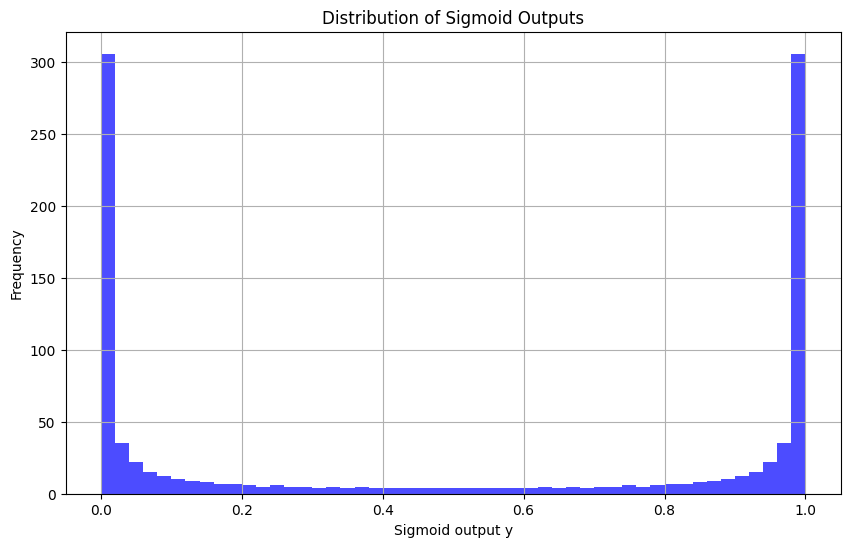

In [3]:
x = np.linspace(-10, 10, 1000) # -10부터 10까지 1000개의 값
y = sigmoid(x) # Sigmoid 함수를 사용하여 출력 데이터 계산

# y값의 분포를 히스토그램으로 시각화
plt.figure(figsize=(10, 6))
plt.hist(y, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Sigmoid Outputs')
plt.xlabel('Sigmoid output y')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

<a id="1-2"></a>
### 1-2.Vanishing gradients

간단한 NN을 제작하는데, 이해를 돕기 위해 코드라인에 대한 설명을 첨부한다.
1. `SimpleNeuralNetwork` 클래스는 `input_size`, `layer_depths`, `layer_widths`를 인자로 받는다. -> 데이터 샘플이 가진 feature 수, NN의 layer 수, 각각의 layer가 갖는 unit의 수.
2. line5 ~ line 11는 N개의 layer들에 대한 정의로 각각의 layer가 갖는 weight matrix를 생성해 weights 리스트에 모두 담는다.
3. 

In [4]:
# 로지스틱 회귀 모델을 위한 간단한 신경망 클래스
class SimpleNeuralNetwork:
    def __init__(self, input_size, layer_depths, layer_widths):
        self.layers = layer_depths
        self.weights = [np.random.randn(input_size, layer_widths[0])] ## first hidden layer

        for i in range(self.layers - 1): ## second ~ nth hidden layers
            weight = np.random.randn(layer_widths[i], layer_widths[i+1])
            self.weights.append(weight)

        self.weights += [np.random.randn(layer_widths[i], 1)] ## output layer

    def print_weights(self):
        for idx, weight in enumerate(self.weights):
            print(f"layer {idx} : {weight.shape}")

    def forward(self, X):
        activations = [X]
        for i in range(self.layers):
            net = np.dot(activations[-1], self.weights[i])
            activations.append(sigmoid(net))

        return activations

    def compute_gradients(self, X, y):
        activations = self.forward(X)
        output = activations[-1]
        errors = [output - y] ## loss
        
        # 역전파: 그래디언트 계산
        gradients = []
        for i in reversed(range(self.layers)):
            delta = errors[-1] * sigmoid_derivative(activations[i+1]) ## dL/d(hat y)  * da/dz
            gradients.append(np.dot(activations[i].T, delta)) ## dL/dz * dz/dw = dL/dz * x^T
            if i != 0:
                errors.append(np.dot(delta, self.weights[i].T))
        gradients = gradients[::-1]
        
        return gradients

In [5]:
X = np.random.randn(10, 3) + 100
y = np.random.randint(0, 2, (10, 1))

In [6]:
layer_depths = 200
layer_widths = [100 for _ in range(layer_depths)]
nn = SimpleNeuralNetwork(input_size=3, layer_depths=layer_depths, layer_widths=layer_widths)

# print(nn.print_weights())

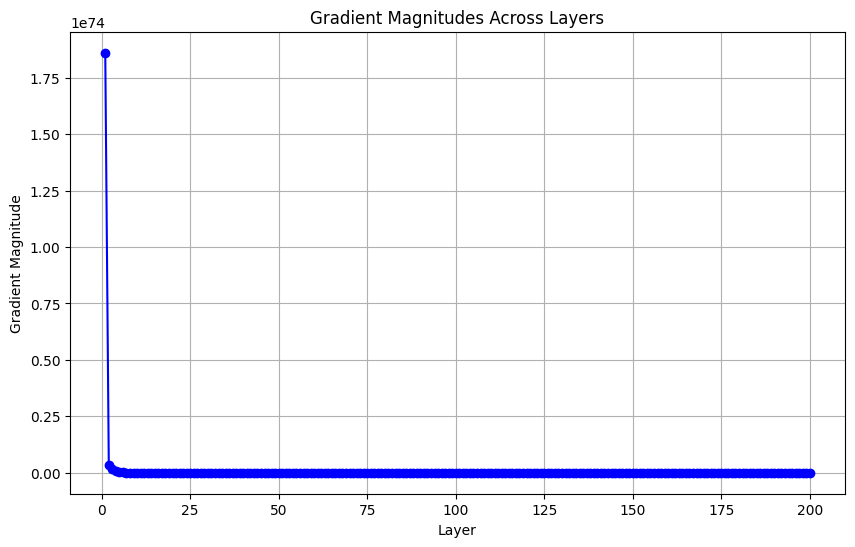

In [7]:
gradients = nn.compute_gradients(X, y)
gradients_magnitudes = [np.linalg.norm(grad) for grad in gradients] ## Gradient는 partial derivative matrix이기 때문에, 행렬에 대한 크기를 계산해서 layer_depths개의 스칼라로 만들어야 한다.

layers = range(1, layer_depths + 1)
plt.figure(figsize=(10, 6))
plt.plot(layers, gradients_magnitudes, marker='o', linestyle='-', color='b')
plt.title('Gradient Magnitudes Across Layers')
plt.xlabel('Layer')
plt.ylabel('Gradient Magnitude')
plt.grid(True)
plt.show()

<a id="2"></a>
## Tanh
$$ \tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} $$

- zero center function
- sigmoid와 마찬가지로 saturated region 존재.

In [8]:
def tanh(x):
    head = np.exp(x) - np.exp(-x)
    tail = np.exp(x) + np.exp(-x)

    return head / tail

tanh 함수의 출력값(함수값)에 대한 그래프를 그려보면, 0을 중심축으로 값들이 분포되어 있는 것을 확인할 수 있다.

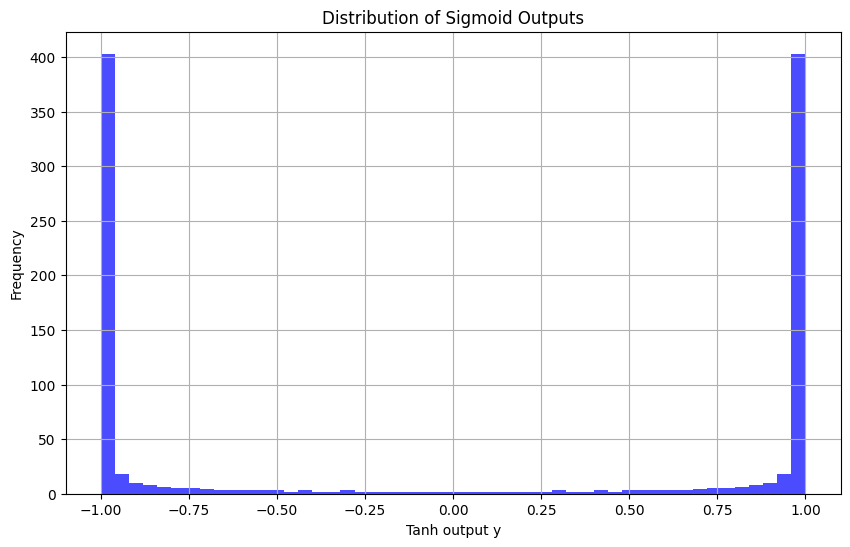

In [9]:
x = np.linspace(-10, 10, 1000)
y = tanh(x)

plt.figure(figsize=(10, 6))
plt.hist(y, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Sigmoid Outputs')
plt.xlabel('Tanh output y')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

<a id="3"></a>
## ReLU

$$ \text{ReLU}(x) = max(0, z)$$
$$
\text{ReLU}'(x) = 
\begin{cases} 
0, & \text{if } x < 0 \\
1, & \text{if } x \geq 0 
\end{cases}
$$


- 입력값이 0보다 작을 때는 0으로 출력. -> saturated region
- 1이상의 입력값은 입력값을 그대로 출력한다.(Linearity) -> non saturated region

In [10]:
def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)


In [11]:
class SimpleNeuralNetwork:
    def __init__(self, input_size, layer_depths, layer_widths):
        self.layers = layer_depths
        self.weights = [np.random.randn(input_size, layer_widths[0])] ## first hidden layer

        for i in range(self.layers - 1): ## second ~ nth hidden layers
            weight = np.random.randn(layer_widths[i], layer_widths[i+1])
            self.weights.append(weight)

        self.weights += [np.random.randn(layer_widths[i], 1)] ## output layer

    def print_weights(self):
        for idx, weight in enumerate(self.weights):
            print(f"layer {idx} : {weight.shape}")

    def forward(self, X):
        activations = [X]
        for i in range(self.layers):
            net = np.dot(activations[-1], self.weights[i])
            activations.append(relu(net)) ## sigmoid -> relu

        return activations

    def compute_gradients(self, X, y):
        activations = self.forward(X)
        output = activations[-1]
        errors = [output - y] ## loss
        
        # 역전파: 그래디언트 계산
        gradients = []
        for i in reversed(range(self.layers)):
            delta = errors[-1] * relu_derivative(activations[i+1]) ## dL/d(hat y)  * da/dz
            gradients.append(np.dot(activations[i].T, delta)) ## dL/dz * dz/dw = dL/dz * x^T
            if i != 0:
                errors.append(np.dot(delta, self.weights[i].T))
        gradients = gradients[::-1]
        
        return gradients

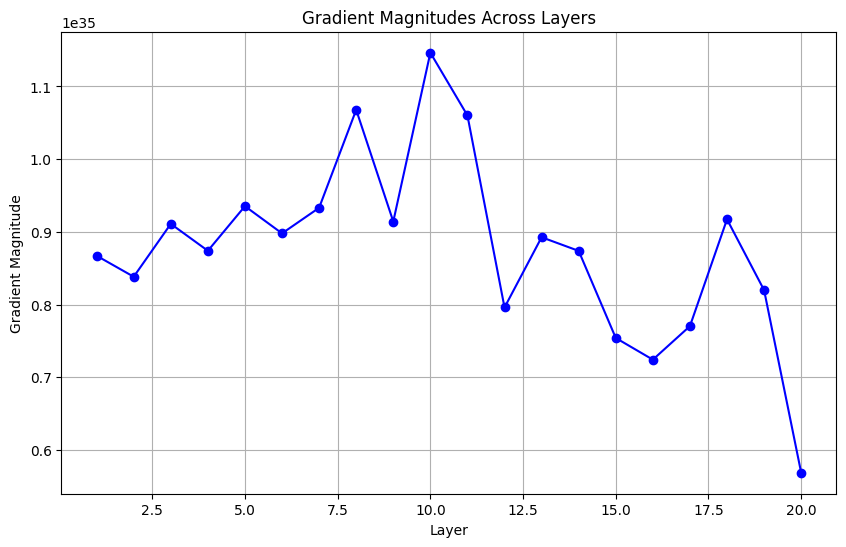

In [12]:
X = np.random.randn(10, 3)
y = np.random.randint(0, 2, (10, 1))

layer_depths = 20
layer_widths = [100 for _ in range(layer_depths)]
nn = SimpleNeuralNetwork(input_size=3, layer_depths=layer_depths, layer_widths=layer_widths)

# print(nn.print_weights())

gradients = nn.compute_gradients(X, y)
gradients_magnitudes = [np.linalg.norm(grad) for grad in gradients]

layers = range(1, layer_depths + 1)
plt.figure(figsize=(10, 6))
plt.plot(layers, gradients_magnitudes, marker='o', linestyle='-', color='b')
plt.title('Gradient Magnitudes Across Layers')
plt.xlabel('Layer')
plt.ylabel('Gradient Magnitude')
plt.grid(True)
plt.show()

<a id="4"></a>
## 4.Stochastic Gradient Descent

<a id="4-1"></a>
### 4-1.Load Dataset

In [15]:
df=pd.read_csv("/home/pervinco/DL-basic/data/Social_Network_Ads.csv")
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [16]:
df['Gender'] = (df['Gender'] =='Male').astype(int)
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,1,19,19000,0
1,15810944,1,35,20000,0
2,15668575,0,26,43000,0
3,15603246,0,27,57000,0
4,15804002,1,19,76000,0


In [17]:
y = df['Purchased']
df = df.drop(columns = ['User ID','Purchased'])

In [18]:
train_x, test_x, train_y, test_y = train_test_split(df, y, test_size=0.1, random_state=0)

train_x = np.array(train_x).T
train_y = np.expand_dims(train_y, axis=0)

test_x = np.array(test_x).T
test_y = np.expand_dims(test_y, axis=0)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(3, 360) (1, 360)
(3, 40) (1, 40)


In [19]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []

    ## Shuffle
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))

    num_mini_batches = math.floor(m / mini_batch_size)
    for k in range(0, num_mini_batches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    ## 마지막 미니배치의 크기가 batch_size와 다른 경우. 나머지 데이터들을 묶어서 미니 배치를 생성.
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_mini_batches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_mini_batches * mini_batch_size:]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

<a id="4-2"></a>
### 4-2.Forward & Backward with Mini-Batch

In [20]:
def initialize_parameters_random(layers_dims):
    """
    Normal Distribution을 기반으로 랜덤값을 선정.

    Arguments:
     - layer_dims : 각 layer에 설정할 unit의 수. list 타입
    
    Returns:
     - parameters : 각 layer에 설정되는 weight(matrix, "W1", "W2",..."WL"), bias(vector, "b1", "b2",..."bL")의 dictionary 타입
                    W1 : weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 : bias vector of shape (layers_dims[1], 1)
                    ...
                    WL : weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL : bias vector of shape (layers_dims[L], 1)
    """
    np.random.seed(3)

    parameters = {}
    L = len(layers_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 10
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

def initialize_parameters_he(layers_dims):  
    ## He Normal Distribution을 따라 확률 변수들에 확률을 부여하고, 랜덤으로 가중치 값을 선정.
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2 / layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
                
    return parameters

In [21]:
def forward_propagation(X, parameters):
    """
    Arguments:
     - X : input data (n_x, m) n_x는 feature 수, m은 데이터 샘플 수
     - parameters : 각 layer의 trainable params dict타입 {"W1", "b1", ..., "WL", "bL"}

    Returns:
     - AL : 출력층(L번째 layer)의 activation feature
     - caches : 각 층의 (input, weight, bias, output)
    """
    caches = []
    A = X
    L = len(parameters) // 2
    
    # [LINEAR -> RELU]*(L-1)
    for l in range(1, L):
        A_prev = A 
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        Z = np.dot(W, A_prev) + b
        A = np.maximum(0, Z)  # ReLU
        cache = (A_prev, W, b, Z)
        caches.append(cache)
        
    # LINEAR -> SIGMOID
    WL = parameters['W' + str(L)]
    bL = parameters['b' + str(L)]
    ZL = np.dot(WL, A) + bL
    AL = 1 / (1 + np.exp(-ZL))  # Sigmoid AL = sigmoid(ZL)
    cache = (A, WL, bL, ZL)
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    
    return AL, caches

In [22]:
def compute_cost(AL, Y):
    """
    Arguments:
     - AL : label 예측에 해당하는 확률 벡터. (1, num of data samples)
     - Y : ground-truth 벡터. (1, num of data samples)

    Returns:
     - cost : cross-entropy cost
    """
    m = Y.shape[1]

    # logprobs = np.multiply(np.log(AL), Y) + np.multiply((1 - Y), np.log(1 - AL))
    logprobs = np.multiply(np.log(AL + 1e-8), Y) + np.multiply((1 - Y), np.log(1 - AL + 1e-8))

    cost = -np.sum(logprobs) / m

    cost = float(np.squeeze(cost))

    return cost

In [23]:
def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0

    return dZ

def sigmoid_backward(dA, Z):
    S = sigmoid(Z)
    dZ = dA * S * (1-S)

    return dZ

def backward_propagation(X, Y, caches, AL):
    """
    Backward Propagation.
    L-1개의 [Linear -> ReLU] layer와 출력층 [Linear -> Sigmoid]의 parameter에 대한 gradient를 계산한다.

    Arguments:
     - X : 입력 데이터. (n_x, m) n_x는 feature 수, m은 데이터 샘플의 수
     - Y : ground_truth. (1, m)
     - caches : list 타입. 각 layer의 (input, weight, bias, output).
     - AL : 마지막 출력층의 출력값. y hat.
    """
    grads = {}
    L = len(caches) ## layer 수
    m = X.shape[1] ## 데이터 샘플의 수

    ## cost function gradient
    # dAL = -(np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    dAL = -(np.divide(Y, AL + 1e-8) - np.divide(1 - Y, 1 - AL + 1e-8))

    ## L번째 layer(출력층) [sigmoid -> Linear] gradient
    cache = caches[-1]
    A_prev, WL, bL, ZL = cache
    dZL = sigmoid_backward(dAL, ZL) ## dL/dA * dA/dZ = dL / dZ
    dWL = np.dot(dZL, A_prev.T) ## dL/dZ * dZ/dW = dL/dW
    dbL = np.sum(dZL, axis=1, keepdims=True) / m ## dL/dZ * dZ/db = dL/db
    dA_prev = np.dot(WL.T, dZL) ## dL/dZ * dZ/dX = dL/dX

    grads["dA" + str(L)] = dA_prev
    grads["dW" + str(L)] = dWL
    grads["db" + str(L)] = dbL

    for l in reversed(range(L-1)):
        cache = caches[l]
        A_prev, W, b, Z = cache
        dZ = relu_backward(grads["dA" + str(l + 2)], Z)
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        dA_prev = np.dot(W.T, dZ)

        grads["dA" + str(l + 1)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db
    
    return grads

In [24]:
def update_parameters_with_gradient_descent(parameters, grads, learning_rate):
    """
    Gradient Descent 방식으로 parameter를 업데이트.

    Arguments:
     - parameters : dict 타입. layer에 설정된 weight, bias
     - grads : dict 타입. 각 parameter에 대한 gradients
     - learning rate : 실수형. 

    Returns:
     - parameters : dict 타입. gradient로 업데이트된 parameters
    """
    L = len(parameters) // 2 ## nn을 구성하는 layer 수

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads['dW' + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads['db' + str(l)]

    return parameters

In [25]:
def model(X, Y, layers_dims, learning_rate=0.01, batch_size=64, num_epochs=5000, print_cost=True):
    """
    LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
     - X : input (feature의 수, 데이터 샘플의 수)
     - Y : ground-truth (1, 데이터 샘플의 수)
     - learning_rate
     - num_iterations : 학습 iteration 수.
     - print_cost : iteration마다 cost를 출력할 것인가?
     - initialization : weight initialization 방법 선택 ("zeros","random" or "he")
    
    Returns:
     - parameters : 학습된 parameter
     - costs : 학습동안 발생한 cost list
    """
    t = 0
    seed = 10
    grads = {}
    costs = []
    m = X.shape[1]    
    # parameters = initialize_parameters_he(layers_dims)
    parameters = initialize_parameters_random(layers_dims)

    for i in range(num_epochs):
        cost_total = 0
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        cost_total = 0
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, caches = forward_propagation(mini_batch_X, parameters)
        
            # Cost
            cost_total += compute_cost(AL, mini_batch_Y)

            # Backward propagation.
            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches, AL)
        
            # Update parameters.
            parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
        
        cost_avg = cost_total / m
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.011552
Cost after epoch 1000: 0.011034
Cost after epoch 2000: 0.011065


Cost after epoch 3000: 0.011039
Cost after epoch 4000: 0.011039


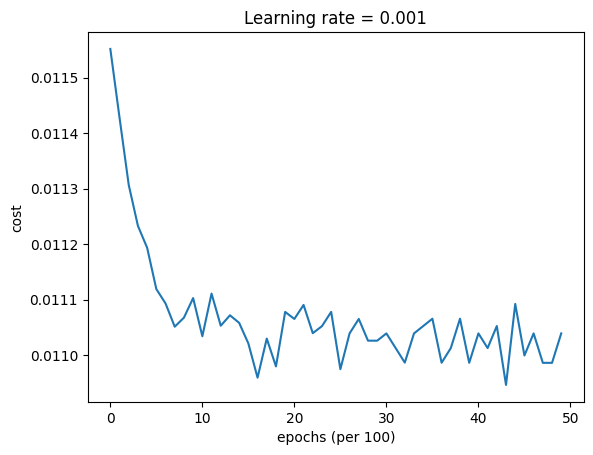

In [26]:
parameters = model(train_x, train_y, layers_dims=[train_x.shape[0], 4, 2, 1], learning_rate=0.001, batch_size=64, num_epochs=5000)

<a id="#5"></a>
## 5. SGD + Momentum

In [27]:
def initialize_velocity(parameters):
    v = {}
    L = len(parameters) // 2
    for l in range(1, L+1):
        v["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        v["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
    
    return v

In [28]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L+1):
        v["dW" + str(l)] = beta * v["dW" + str(l)] + (1 - beta) * grads["dW" + str(l)]
        v["db" + str(l)] = beta * v["db" + str(l)] + (1 - beta) * grads["db" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v["db" + str(l)]  
    
    return parameters, v

In [29]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.01, beta=0.9, batch_size=64, num_epochs=5000, print_cost=True):
    """
    LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
     - X : input (feature의 수, 데이터 샘플의 수)
     - Y : ground-truth (1, 데이터 샘플의 수)
     - learning_rate
     - num_iterations : 학습 iteration 수.
     - print_cost : iteration마다 cost를 출력할 것인가?
     - initialization : weight initialization 방법 선택 ("zeros","random" or "he")
    
    Returns:
     - parameters : 학습된 parameter
     - costs : 학습동안 발생한 cost list
    """
    t = 0
    seed = 10
    grads = {}
    costs = []
    m = X.shape[1]    
    # parameters = initialize_parameters_he(layers_dims)
    parameters = initialize_parameters_random(layers_dims)

    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)

    for i in range(num_epochs):
        cost_total = 0
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        cost_total = 0
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, caches = forward_propagation(mini_batch_X, parameters)
        
            # Cost
            cost_total += compute_cost(AL, mini_batch_Y)

            # Backward propagation.
            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches, AL)
        
            # Update parameters.
            if optimizer == "gd":
                parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
        
        cost_avg = cost_total / m
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.011552
Cost after epoch 1000: 0.011034
Cost after epoch 2000: 0.011065
Cost after epoch 3000: 0.011039
Cost after epoch 4000: 0.011039


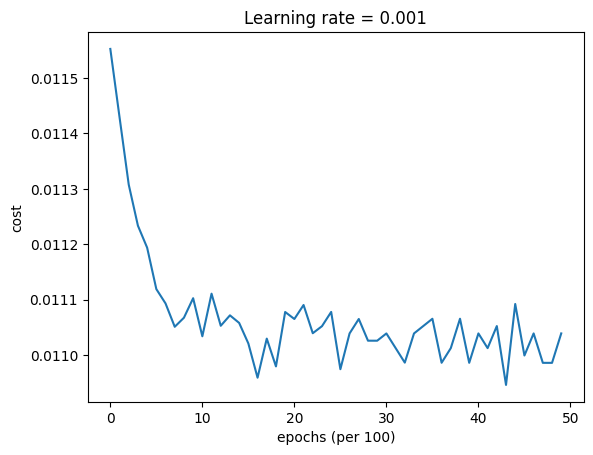

In [30]:
parameters = model(train_x, train_y, optimizer="momentum", layers_dims=[train_x.shape[0], 4, 2, 1], learning_rate=0.001, beta=0.9, num_epochs=5000)

## 6.Adagrad

In [31]:
def initialize_adagrad(parameters):
    s = {}
    L = len(parameters) // 2
    for l in range(1, L + 1):
        s["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        s["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
    
    return s

In [32]:
def update_parameters_with_adagrad(parameters, grads, s, learning_rate, epsilon=1e-8):
    L = len(parameters) // 2
    for l in range(1, L + 1):
        # 누적 제곱 그래디언트 업데이트
        s["dW" + str(l)] += np.square(grads["dW" + str(l)])
        s["db" + str(l)] += np.square(grads["db" + str(l)])
        
        # 매개변수 업데이트
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)] / (np.sqrt(s["dW" + str(l)]) + epsilon)
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)] / (np.sqrt(s["db" + str(l)]) + epsilon)
    
    return parameters, s

In [33]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.01, beta=0.9, batch_size=64, num_epochs=5000, print_cost=True):
    """
    LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
     - X : input (feature의 수, 데이터 샘플의 수)
     - Y : ground-truth (1, 데이터 샘플의 수)
     - learning_rate
     - num_iterations : 학습 iteration 수.
     - print_cost : iteration마다 cost를 출력할 것인가?
     - initialization : weight initialization 방법 선택 ("zeros","random" or "he")
    
    Returns:
     - parameters : 학습된 parameter
     - costs : 학습동안 발생한 cost list
    """
    t = 0
    seed = 10
    grads = {}
    costs = []
    m = X.shape[1]    
    # parameters = initialize_parameters_he(layers_dims)
    parameters = initialize_parameters_random(layers_dims)

    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adagrad":
        s = initialize_adagrad(parameters)

    for i in range(num_epochs):
        cost_total = 0
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        cost_total = 0
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, caches = forward_propagation(mini_batch_X, parameters)
        
            # Cost
            cost_total += compute_cost(AL, mini_batch_Y)

            # Backward propagation.
            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches, AL)
        
            # Update parameters.
            if optimizer == "gd":
                parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adagrad":
                parameters, s = update_parameters_with_adagrad(parameters, grads, s, learning_rate)
        
        cost_avg = cost_total / m
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.011548
Cost after epoch 1000: 0.011311
Cost after epoch 2000: 0.011262
Cost after epoch 3000: 0.011210
Cost after epoch 4000: 0.011179


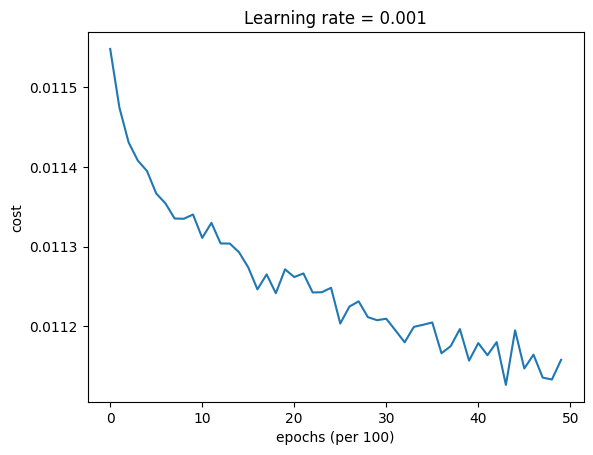

In [34]:
parameters = model(train_x, train_y, optimizer="adagrad", layers_dims=[train_x.shape[0], 4, 2, 1], learning_rate=0.001, num_epochs=5000)

## 7.RMSProp

In [35]:
def initialize_rmsprop(parameters):
    s = {}
    L = len(parameters) // 2
    for l in range(1, L + 1):
        s["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        s["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
    
    return s

In [36]:
def update_parameters_with_rmsprop(parameters, grads, s, beta, learning_rate, epsilon=1e-8):
    L = len(parameters) // 2
    for l in range(1, L + 1):
        # 가중치의 제곱 그라디언트의 이동 평균 업데이트
        s["dW" + str(l)] = beta * s["dW" + str(l)] + (1 - beta) * np.square(grads["dW" + str(l)])
        s["db" + str(l)] = beta * s["db" + str(l)] + (1 - beta) * np.square(grads["db" + str(l)])
        
        # 매개변수 업데이트
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)] / (np.sqrt(s["dW" + str(l)]) + epsilon)
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)] / (np.sqrt(s["db" + str(l)]) + epsilon)
    
    return parameters, s


In [37]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.01, beta=0.9, batch_size=64, num_epochs=5000, print_cost=True):
    """
    LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
     - X : input (feature의 수, 데이터 샘플의 수)
     - Y : ground-truth (1, 데이터 샘플의 수)
     - learning_rate
     - num_iterations : 학습 iteration 수.
     - print_cost : iteration마다 cost를 출력할 것인가?
     - initialization : weight initialization 방법 선택 ("zeros","random" or "he")
    
    Returns:
     - parameters : 학습된 parameter
     - costs : 학습동안 발생한 cost list
    """
    t = 0
    seed = 10
    grads = {}
    costs = []
    m = X.shape[1]    
    # parameters = initialize_parameters_he(layers_dims)
    parameters = initialize_parameters_random(layers_dims)

    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adagrad":
        s = initialize_adagrad(parameters)
    elif optimizer == "rmsprop":
        s = initialize_rmsprop(parameters)

    for i in range(num_epochs):
        cost_total = 0
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        cost_total = 0
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, caches = forward_propagation(mini_batch_X, parameters)
        
            # Cost
            cost_total += compute_cost(AL, mini_batch_Y)

            # Backward propagation.
            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches, AL)
        
            # Update parameters.
            if optimizer == "gd":
                parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adagrad":
                parameters, s = update_parameters_with_adagrad(parameters, grads, s, learning_rate)
            elif optimizer == "rmsprop":
                parameters, s = update_parameters_with_rmsprop(parameters, grads, s, beta, learning_rate)
        
        cost_avg = cost_total / m
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.011539


Cost after epoch 1000: 0.011000
Cost after epoch 2000: 0.011067
Cost after epoch 3000: 0.011040
Cost after epoch 4000: 0.011040


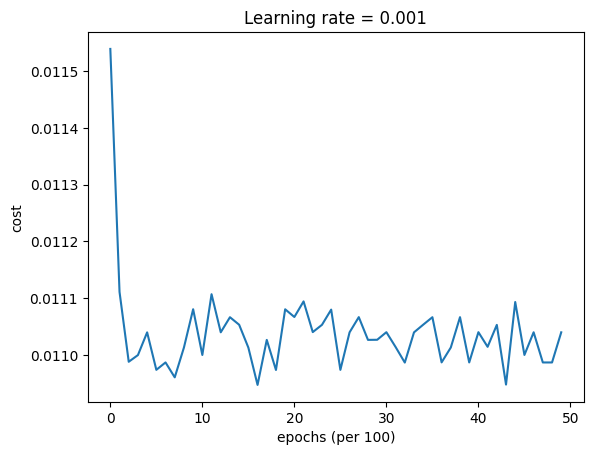

In [38]:
parameters = model(train_x, train_y, optimizer="rmsprop", layers_dims=[train_x.shape[0], 4, 2, 1], learning_rate=0.001, beta=0.9, num_epochs=5000)

## 8.Adam

In [39]:
def initialize_adam(parameters):
    v, s = {}, {}
    L = len(parameters) // 2

    for l in range(1, L+1):
        v["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        v["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
        s["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        s["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])

    return v, s

In [40]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}

    for l in range(1, L+1):
        ## First Moment
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads["dW" + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads["db" + str(l)]

        ## Bias correction
        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - np.power(beta1, t))

        ## Second Moment
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * np.square(grads["dW" + str(l)])
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * np.square(grads["db" + str(l)]) 

        ## Bias Correction
        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - np.power(beta2, t))

        ## update
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon)

    return parameters, v, s, v_corrected, s_corrected

In [41]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.01, beta=0.9, beta1=0.9, beta2=0.999, batch_size=64, num_epochs=5000, print_cost=True):
    """
    LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
     - X : input (feature의 수, 데이터 샘플의 수)
     - Y : ground-truth (1, 데이터 샘플의 수)
     - learning_rate
     - num_iterations : 학습 iteration 수.
     - print_cost : iteration마다 cost를 출력할 것인가?
     - initialization : weight initialization 방법 선택 ("zeros","random" or "he")
    
    Returns:
     - parameters : 학습된 parameter
     - costs : 학습동안 발생한 cost list
    """
    t = 0
    seed = 10
    grads = {}
    costs = []
    m = X.shape[1]    
    # parameters = initialize_parameters_he(layers_dims)
    parameters = initialize_parameters_random(layers_dims)

    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adagrad":
        s = initialize_adagrad(parameters)
    elif optimizer == "rmsprop":
        s = initialize_rmsprop(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    for i in range(num_epochs):
        cost_total = 0
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        cost_total = 0
        for minibatch in minibatches:
            mini_batch_X, mini_batch_Y = minibatch

            # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
            AL, caches = forward_propagation(mini_batch_X, parameters)
        
            # Cost
            cost_total += compute_cost(AL, mini_batch_Y)

            # Backward propagation.
            grads = backward_propagation(mini_batch_X, mini_batch_Y, caches, AL)
        
            # Update parameters.
            if optimizer == "gd":
                parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adagrad":
                parameters, s = update_parameters_with_adagrad(parameters, grads, s, learning_rate)
            elif optimizer == "rmsprop":
                parameters, s = update_parameters_with_rmsprop(parameters, grads, s, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2)
        
        cost_avg = cost_total / m
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.011548


Cost after epoch 1000: 0.010999
Cost after epoch 2000: 0.011066
Cost after epoch 3000: 0.011039
Cost after epoch 4000: 0.011040


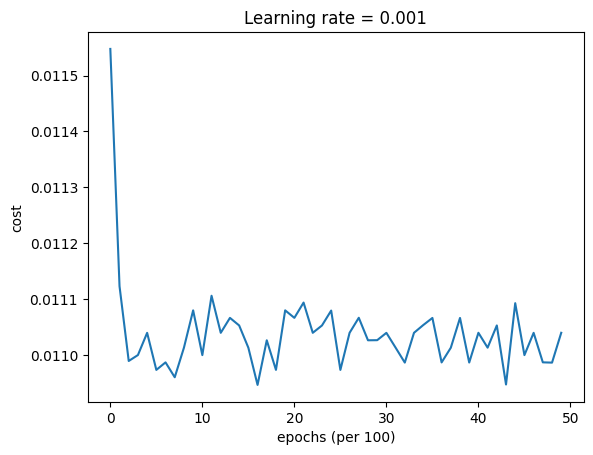

In [42]:
parameters = model(train_x, train_y, optimizer="adam", layers_dims=[train_x.shape[0], 4, 2, 1], learning_rate=0.001, beta=0.9, beta1=0.9, beta2=0.999, num_epochs=5000)